In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt

In [3]:
# Path to your shapefile
path = "./trimmed_manhattan_shape/trimmed_manhattan.shp"

gdf = gpd.read_file(path)

In [4]:
print("CRS:", gdf.crs)
print("Geometry types:", gdf.geom_type.unique())
print("Columns:", gdf.columns.tolist())

CRS: EPSG:4326
Geometry types: ['LineString']
Columns: ['osm_id', 'name', 'highway', 'oneway', 'geometry']


In [5]:
print("CRS:", gdf.crs)
print("Geometry types:", gdf.geom_type.unique())
print("Columns:", gdf.columns.tolist())

CRS: EPSG:4326
Geometry types: ['LineString']
Columns: ['osm_id', 'name', 'highway', 'oneway', 'geometry']


In [6]:
gdf.head(10)

,osm_id,name,highway,oneway,geometry
0,132500852,Dyckman Street,secondary,None,"LINESTRING (-73.93117 40.86876, -73.93035 40.8..."
1,1098148716,Riverside Drive,secondary,yes,"LINESTRING (-73.95539 40.82344, -73.95537 40.8..."
2,422298615,5th Avenue,secondary,yes,"LINESTRING (-73.97348 40.76365, -73.97353 40.7..."
3,295999078,West 100th Street,residential,yes,"LINESTRING (-73.97314 40.79858, -73.9731 40.79..."
4,275298540,West 112th Street,residential,yes,"LINESTRING (-73.95448 40.8007, -73.95431 40.80..."
5,46481740,West 38th Street,residential,yes,"LINESTRING (-73.9989 40.75776, -73.99855 40.75..."
6,420904618,West 42nd Street,primary,None,"LINESTRING (-73.99547 40.75963, -73.99534 40.7..."
7,544549058,East 56th Street,residential,yes,"LINESTRING (-73.96806 40.7596, -73.96795 40.75..."
8,1123883122,West 79th Street,secondary,None,"LINESTRING (-73.97988 40.78381, -73.98008 40.7..."
9,5670859,Morningside Avenue,residential,no,"LINESTRING (-73.95819 40.80561, -73.95813 40.8..."


In [7]:
# If CRS is geographic (lat/lon), reproject to EPSG: 2263 (NY State Plane)
if gdf.crs is not None and gdf.crs.is_geographic:
    gdf = gdf.to_crs(epsg=2263)
    print("Reprojected CRS: ", gdf.crs)

Reprojected CRS:  EPSG:2263


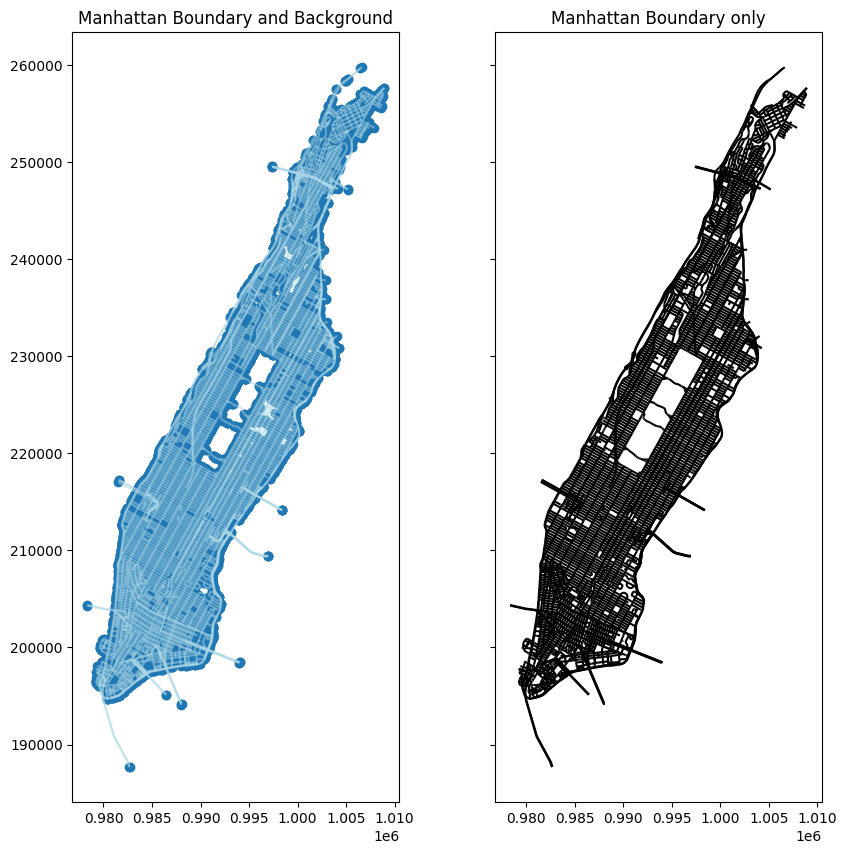

In [8]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10, 10), sharey=True)
gdf.boundary.plot(ax=ax1, linewidth=1)
gdf.plot(ax=ax1, alpha=0.5, color="lightblue", edgecolor="black")
ax1.set_title("Manhattan Boundary and Background")

gdf.plot(ax = ax2,figsize=(8, 8), edgecolor="black", facecolor="none")
ax2.set_title("Manhattan Boundary only")

plt.show()

In [9]:
from dataclasses import dataclass
from typing import Dict, List, Tuple
from collections import defaultdict
from shapely.geometry import LineString, MultiLineString

Node = Tuple[float, float]     # (x, y)
EdgeId = Tuple[Node, Node]     # directed edge


@dataclass
class Edge:
    start: Node
    end: Node
    free_time: float      # e.g. seconds
    capacity: float       # vehicles per time unit
    alpha: float = 0.15   # BPR parameters
    beta: float = 4.0

    def travel_time(self, flow: float) -> float:
        x = flow / self.capacity if self.capacity > 0 else 0.0
        return self.free_time * (1.0 + self.alpha * (x ** self.beta))


Graph = Dict[Node, List[EdgeId]]


@dataclass
class TrafficNetwork:
    graph: Graph
    edges: Dict[EdgeId, Edge]


In [10]:
def make_node(x: float, y: float, ndigits: int = 3) -> Node:
    # rounding keeps nodes consistent instead of having tiny float differences
    return round(x, ndigits), round(y, ndigits)

In [11]:
def network_from_streets_gdf(
    streets_gdf: gpd.GeoDataFrame,
    default_speed_m_s: float = 8.33,   # ~30 km/h
    default_capacity: float = 500.0    # arbitrary, you can tune
) -> TrafficNetwork:

    graph: Dict[Node, List[EdgeId]] = defaultdict(list)
    edges: Dict[EdgeId, Edge] = {}

    for idx, row in streets_gdf.iterrows():
        geom = row.geometry
        if geom is None:
            continue

        # Handle MultiLineString and LineString
        if isinstance(geom, MultiLineString):
            line_geoms = list(geom.geoms)
        elif isinstance(geom, LineString):
            line_geoms = [geom]
        else:
            continue  # ignore other types

        for line in line_geoms:
            coords = list(line.coords)
            if len(coords) < 2:
                continue

            # edges between consecutive points
            for (x1, y1), (x2, y2) in zip(coords[:-1], coords[1:]):
                u = make_node(x1, y1)
                v = make_node(x2, y2)

                seg = LineString([(x1, y1), (x2, y2)])
                length_m = seg.length

                free_time = length_m / default_speed_m_s if default_speed_m_s > 0 else 1.0

                # directed edge u -> v
                e1 = (u, v)
                if e1 not in edges:
                    edges[e1] = Edge(start=u, end=v,
                                     free_time=free_time,
                                     capacity=default_capacity)
                    graph[u].append(e1)

                # if you want bidirectional by default
                e2 = (v, u)
                if e2 not in edges:
                    edges[e2] = Edge(start=v, end=u,
                                     free_time=free_time,
                                     capacity=default_capacity)
                    graph[v].append(e2)

    return TrafficNetwork(graph=dict(graph), edges=edges)

### Build the graph

In [12]:
manhattan_network = network_from_streets_gdf(gdf)
print(f"# nodes: {len(manhattan_network.graph)}")
print(f"# edges: {len(manhattan_network.edges)}")

# nodes: 37086
# edges: 81228


### Convert to NetworkX

# NX nodes: 37086 # NX edges: 81228


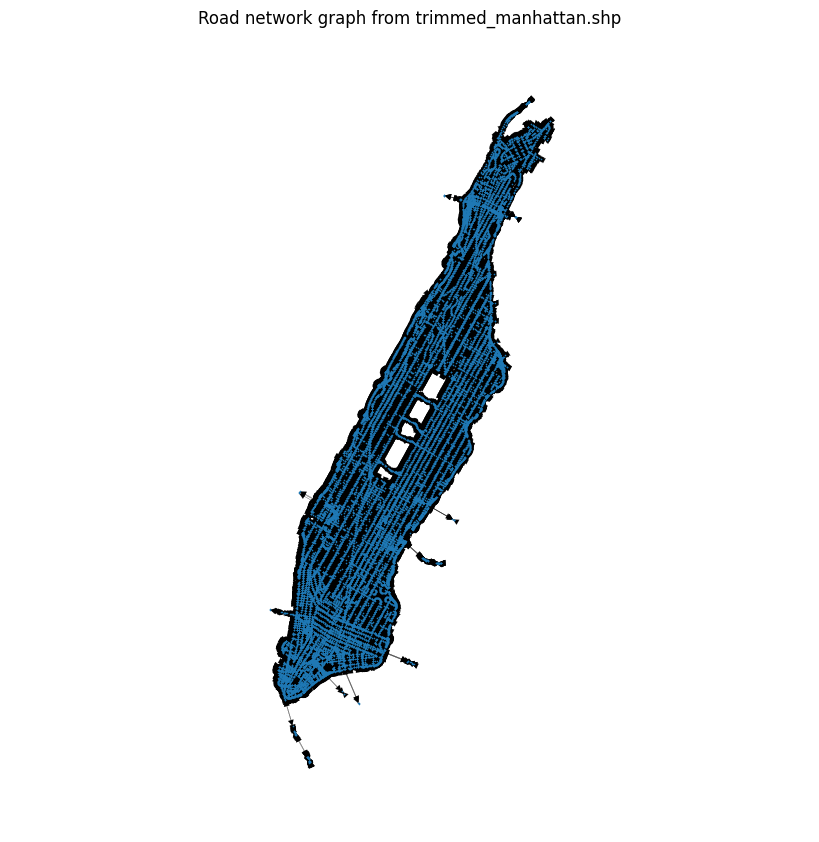

In [13]:
import networkx as nx
import matplotlib.pyplot as plt

def to_networkx(network: TrafficNetwork) -> nx.DiGraph:
    G = nx.DiGraph()
    for node in network.graph.keys():
        G.add_node(node, x=node[0], y=node[1])
    for e_id, edge in network.edges.items():
        G.add_edge(edge.start, edge.end,
                   free_time=edge.free_time,
                   capacity=edge.capacity)
    return G

G_nx = to_networkx(manhattan_network)
print("# NX nodes:", G_nx.number_of_nodes(), "# NX edges:", G_nx.number_of_edges())

pos = {n: (n[0], n[1]) for n in G_nx.nodes()}
plt.figure(figsize=(8, 8))
nx.draw(G_nx, pos=pos, node_size=1, linewidths=0.1, width=0.1)
plt.axis("equal")
plt.title("Road network graph from trimmed_manhattan.shp")
plt.show()

### Agents + OD selection

In [14]:
Node = Tuple[float, float]       # already used in your network
EdgeId = Tuple[Node, Node]       # directed edge
EdgeFlows = Dict[EdgeId, float]  # flow per edge


@dataclass
class Agent:
    origin: Node
    destination: Node
    path: List[Node] = None

### Random selection

In [15]:
import random

def sample_agents_random(network, num_agents: int) -> List[Agent]:
    nodes = list(network.graph.keys())
    agents: List[Agent] = []
    for _ in range(num_agents):
        o = random.choice(nodes)
        d = random.choice(nodes)
        while d == o:
            d = random.choice(nodes)
        agents.append(Agent(origin=o, destination=d))
    return agents

### North to Sout Commute

In [16]:
def sample_agents_north_south(network, num_agents: int, band_split: float = 0.5) -> List[Agent]:
    nodes = list(network.graph.keys())
    ys = [y for (_, y) in nodes]
    y_min, y_max = min(ys), max(ys)
    y_mid = y_min + band_split * (y_max - y_min)

    north_nodes = [n for n in nodes if n[1] >= y_mid]
    south_nodes = [n for n in nodes if n[1] <= y_mid]

    assert north_nodes and south_nodes, "North/south bands are empty – check CRS or band_split."

    agents: List[Agent] = []
    for _ in range(num_agents):
        o = random.choice(north_nodes)
        d = random.choice(south_nodes)
        agents.append(Agent(origin=o, destination=d))
    return agents

### Dijkstra on TrafficNetwork

In [17]:
import heapq
from typing import Optional

def dijkstra(network,
             source: Node,
             target: Node,
             edge_flows: EdgeFlows) -> List[Node]:
    graph, edges = network.graph, network.edges

    dist: Dict[Node, float] = {source: 0.0}
    prev: Dict[Node, Node] = {}
    pq = [(0.0, source)]
    visited = set()

    while pq:
        d, u = heapq.heappop(pq)
        if u in visited:
            continue
        visited.add(u)

        if u == target:
            break

        for edge_id in graph.get(u, []):
            edge = edges[edge_id]
            v = edge.end
            w = edge.travel_time(edge_flows[edge_id])  # cost depends on current flow
            nd = d + w

            if v not in dist or nd < dist[v]:
                dist[v] = nd
                prev[v] = u
                heapq.heappush(pq, (nd, v))

    if target not in dist:
        return []  # no path found

    # Reconstruct path
    path: List[Node] = []
    cur = target
    while cur != source:
        path.append(cur)
        cur = prev[cur]
    path.append(source)
    path.reverse()
    return path

### Utility function: get edges from a path

In [18]:
def edges_from_path(path: List[Node]) -> List[EdgeId]:
    return list(zip(path[:-1], path[1:]))

### SPA routing: selfish, sequential assignment

In [19]:
def spa_route_all(network, agents: List[Agent]) -> Tuple[List[Agent], EdgeFlows]:
    edge_flows: EdgeFlows = defaultdict(float)
    edges = network.edges

    for agent in agents:
        path = dijkstra(network, agent.origin, agent.destination, edge_flows)
        agent.path = path

        for e in edges_from_path(path):
            edge_flows[e] += 1.0  # 1 vehicle per agent

    return agents, edge_flows

### World Utility

In [20]:
def total_system_travel_time(network, edge_flows: EdgeFlows) -> float:
    total = 0.0
    for e_id, flow in edge_flows.items():
        edge = network.edges[e_id]
        total += flow * edge.travel_time(flow)
    return total

# Coin

In [21]:
def edge_marginal_cost(edge: Edge, flow_before: float) -> float:
    """
    Given that 'flow_before' cars already use this edge,
    what is the marginal increase in global G if one more car uses it?
    """
    f1 = flow_before
    f2 = flow_before + 1

    t1 = edge.travel_time(f1)
    t2 = edge.travel_time(f2)

    G1 = f1 * t1
    G2 = f2 * t2

    return G2 - G1

In [22]:
import random

def get_neighbors(network: TrafficNetwork, node: Node) -> List[Node]:
    return [network.edges[e_id].end for e_id in network.graph.get(node, [])]


def choose_action_eps_greedy(network: TrafficNetwork,
                             Q: Dict[Tuple[Node, Node, Node], float],
                             state_node: Node,
                             dest_node: Node,
                             epsilon: float) -> Node:
    neighbors = get_neighbors(network, state_node)
    if not neighbors:
        return state_node  # dead end, stay put (will break later)

    # exploration
    if random.random() < epsilon:
        return random.choice(neighbors)

    # exploitation: pick neighbor with highest Q
    best_q = None
    best_actions = []
    for a in neighbors:
        key = (state_node, dest_node, a)
        q = Q.get(key, 0.0)
        if best_q is None or q > best_q:
            best_q = q
            best_actions = [a]
        elif q == best_q:
            best_actions.append(a)

    return random.choice(best_actions)

In [23]:
from collections import defaultdict
from typing import Dict, Tuple

def train_coin_rl(
    network: TrafficNetwork,
    episodes: int = 50,
    num_agents: int = 200,
    od_mode: str = "north_south",
    alpha: float = 0.1,
    gamma: float = 0.95,
    epsilon_start: float = 0.5,
    epsilon_end: float = 0.05,
    max_steps_per_agent: int = 200
) -> Dict[Tuple[Node, Node, Node], float]:
    """
    Train a Q-table where Q[(state_node, dest_node, action_node)] estimates
    the negative marginal cost of choosing 'action_node' from 'state_node'
    when going to 'dest_node'.
    """
    Q: Dict[Tuple[Node, Node, Node], float] = {}

    for ep in range(episodes):
        # Linear epsilon decay
        epsilon = epsilon_start + (epsilon_end - epsilon_start) * (ep / max(1, episodes - 1))

        # Reset flows for this "day"
        edge_flows: EdgeFlows = defaultdict(float)

        # Sample agents for this episode
        if od_mode == "random":
            agents = sample_agents_random(network, num_agents)
        else:
            agents = sample_agents_north_south(network, num_agents)

        for agent in agents:
            s = agent.origin
            d = agent.destination
            steps = 0

            while s != d and steps < max_steps_per_agent:
                neighbors = get_neighbors(network, s)
                if not neighbors:
                    break  # dead end

                a = choose_action_eps_greedy(network, Q, s, d, epsilon)

                # find edge
                edge_id = (s, a)
                if edge_id not in network.edges:
                    # if edge not direct (shouldn't happen if get_neighbors is correct)
                    break

                edge = network.edges[edge_id]
                f_before = edge_flows[edge_id]

                # COIN-style reward: negative marginal increase in global cost
                marginal = edge_marginal_cost(edge, f_before)
                reward = -marginal

                # next state
                s_next = a

                # Q-learning update
                key = (s, d, a)
                old_q = Q.get(key, 0.0)

                # best next Q
                next_neighbors = get_neighbors(network, s_next)
                if next_neighbors:
                    max_next_q = max(
                        Q.get((s_next, d, a_next), 0.0)
                        for a_next in next_neighbors
                    )
                else:
                    max_next_q = 0.0

                target = reward + gamma * max_next_q
                Q[key] = old_q + alpha * (target - old_q)

                # move and update flows
                edge_flows[edge_id] += 1.0
                s = s_next
                steps += 1

        print(f"Episode {ep+1}/{episodes} finished, epsilon={epsilon:.3f}")

    return Q

In [24]:
def route_with_trained_Q(
    network: TrafficNetwork,
    Q: Dict[Tuple[Node, Node, Node], float],
    num_agents: int = 200,
    od_mode: str = "north_south",
    max_steps_per_agent: int = 200
) -> Tuple[List[Agent], EdgeFlows, float]:

    # fresh flows
    edge_flows: EdgeFlows = defaultdict(float)

    # sample new agents
    if od_mode == "random":
        agents = sample_agents_random(network, num_agents)
    else:
        agents = sample_agents_north_south(network, num_agents)

    for agent in agents:
        s = agent.origin
        d = agent.destination
        path = [s]
        steps = 0

        while s != d and steps < max_steps_per_agent:
            neighbors = get_neighbors(network, s)
            if not neighbors:
                break

            # greedy: epsilon = 0
            best_q = None
            best_actions = []
            for a in neighbors:
                key = (s, d, a)
                q = Q.get(key, 0.0)
                if best_q is None or q > best_q:
                    best_q = q
                    best_actions = [a]
                elif q == best_q:
                    best_actions.append(a)

            a = random.choice(best_actions)

            edge_id = (s, a)
            if edge_id not in network.edges:
                break

            edge_flows[edge_id] += 1.0
            s = a
            path.append(s)
            steps += 1

        agent.path = path

    # compute G with COIN-RL policy
    G = total_system_travel_time(network, edge_flows)
    return agents, edge_flows, G

### Experiment (function definition)

In [25]:
def run_spa_experiment(network,
                       num_agents: int = 500,
                       od_mode: str = "north_south"):
    if od_mode == "random":
        agents = sample_agents_random(network, num_agents)
    elif od_mode in ("north_south", "north-south"):
        agents = sample_agents_north_south(network, num_agents)
    else:
        raise ValueError(f"Unknown od_mode: {od_mode}")

    agents, edge_flows = spa_route_all(network, agents)
    G = total_system_travel_time(network, edge_flows)

    print(f"SPA experiment with {num_agents} agents ({od_mode} O/D)")
    print(f"Total system travel time G: {G:.2f}")
    print(f"Used edges: {len([e for e,f in edge_flows.items() if f > 0])} / {len(network.edges)}")

    return agents, edge_flows, G

In [29]:
random.seed(42)

num_agents = 1000

# SPA baseline
agents_spa, flows_spa, G_spa = run_spa_experiment(
    manhattan_network,
    num_agents=num_agents,
    od_mode="north_south"
)

# Train COIN-RL
Q = train_coin_rl(
    manhattan_network,
    episodes=100,
    num_agents=num_agents,
    od_mode="north_south",
    alpha=0.1,
    gamma=0.95,
    epsilon_start=0.5,
    epsilon_end=0.05,
)

# Evaluate COIN-RL policy
agents_coin, flows_coin, G_coin = route_with_trained_Q(
    manhattan_network,
    Q,
    num_agents=num_agents,
    od_mode="north_south"
)

print(f"G_SPA   = {G_spa:.2f}")
print(f"G_COIN_RL = {G_coin:.2f}")
print(f"Improvement = {(G_spa - G_coin) / G_spa * 100:.2f}%")

SPA experiment with 1000 agents (north_south O/D)
Total system travel time G: 4278203.46
Used edges: 26997 / 81228
Episode 1/100 finished, epsilon=0.500
Episode 2/100 finished, epsilon=0.495
Episode 3/100 finished, epsilon=0.491
Episode 4/100 finished, epsilon=0.486
Episode 5/100 finished, epsilon=0.482
Episode 6/100 finished, epsilon=0.477
Episode 7/100 finished, epsilon=0.473
Episode 8/100 finished, epsilon=0.468
Episode 9/100 finished, epsilon=0.464
Episode 10/100 finished, epsilon=0.459
Episode 11/100 finished, epsilon=0.455
Episode 12/100 finished, epsilon=0.450
Episode 13/100 finished, epsilon=0.445
Episode 14/100 finished, epsilon=0.441
Episode 15/100 finished, epsilon=0.436
Episode 16/100 finished, epsilon=0.432
Episode 17/100 finished, epsilon=0.427
Episode 18/100 finished, epsilon=0.423
Episode 19/100 finished, epsilon=0.418
Episode 20/100 finished, epsilon=0.414
Episode 21/100 finished, epsilon=0.409
Episode 22/100 finished, epsilon=0.405
Episode 23/100 finished, epsilon=0.4

In [28]:
agents, edge_flows, G_spa = run_spa_experiment(manhattan_network,num_agents=500,od_mode="north_south")

SPA experiment with 500 agents (north_south O/D)
Total system travel time G: 2116645.48
Used edges: 22170 / 81228


### Visualize routes

In [30]:
def routes_to_gdf(agents, crs):
    geoms = []
    for agent in agents:
        # agent.path is a list of (x, y) nodes
        if agent.path is not None and len(agent.path) > 1:
            geoms.append(LineString(agent.path))
    routes_gdf = gpd.GeoDataFrame(geometry=geoms, crs=crs)
    return routes_gdf

In [31]:
routes_gdf = routes_to_gdf(agents, crs=gdf.crs)
print(routes_gdf.head())

                                            geometry
0  LINESTRING (1000531.64 232571.098, 1000519.97 ...
1  LINESTRING (999999.071 247616.754, 999997.105 ...
2  LINESTRING (1002797.606 231888.54, 1002798.919...
3  LINESTRING (1000368.991 248767.321, 1000383.57...
4  LINESTRING (998066.745 236919.445, 998072.313 ...


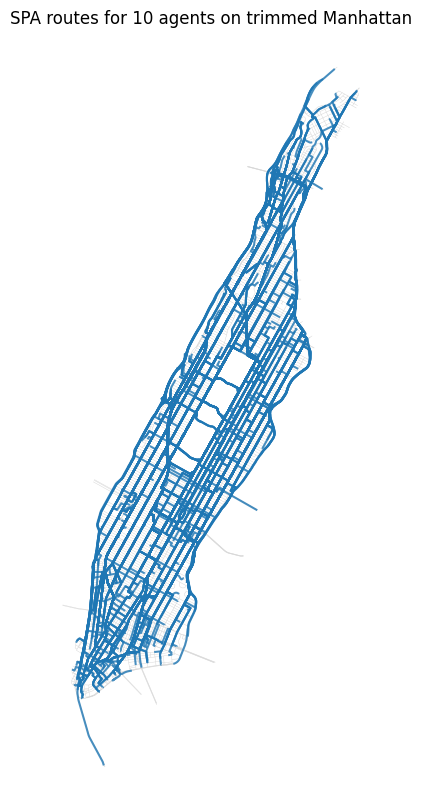

In [34]:
fig, ax = plt.subplots(figsize=(8, 10))

# base map: all streets
gdf.plot(ax=ax, linewidth=0.3, color="lightgray")

# overlay: SPA routes
routes_gdf.plot(ax=ax, linewidth=1.5, alpha=0.8)

ax.set_title("SPA routes for 10 agents on trimmed Manhattan")
ax.set_axis_off()
plt.show()

### Edges flow as heatmap

In [35]:
def edge_flows_to_gdf(edge_flows, network, crs):
    geoms = []
    flows = []
    for (u, v), flow in edge_flows.items():
        if flow <= 0:
            continue
        geoms.append(LineString([u, v]))
        flows.append(flow)
    gdf = gpd.GeoDataFrame({"flow": flows}, geometry=geoms, crs=crs)
    return gdf

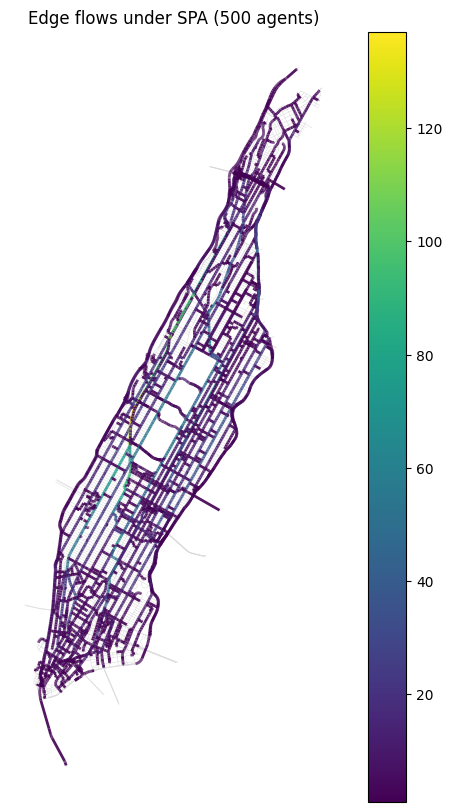

In [36]:
flows_gdf = edge_flows_to_gdf(edge_flows, manhattan_network, crs=gdf.crs)

fig, ax = plt.subplots(figsize=(8, 10))
gdf.plot(ax=ax, linewidth=0.3, color="lightgray")

flows_gdf.plot(
    ax=ax,
    column="flow",
    linewidth=2,
    alpha=0.9,
    legend=True,
    cmap="viridis"   # or any other colormap you like
)

ax.set_title("Edge flows under SPA (500 agents)")
ax.set_axis_off()
plt.show()

# Early Collective Intelligence

In [ ]:
#COLLECTIVE INTELLIGENCE
import numpy as np

@dataclass
class RLAgent:
    origin: Node
    destination: Node
    q_table: Dict[Tuple[Node, EdgeId], float]
    path: List[Node] = None

def init_q_table(network) -> Dict:
    q = {}
    for u, edges in network.graph.items():
        for e in edges:
            q[(u, e)] = 0.0
    return q


In [45]:
def choose_edge(agent: RLAgent, node: Node, network: TrafficNetwork, epsilon=0.2):
    edges = network.graph.get(node, [])
    if not edges:
        return None

    # Exploration
    if random.random() < epsilon:
        return random.choice(edges)

    # Exploitation
    q_vals = [(agent.q_table[(node, e)], e) for e in edges]
    return max(q_vals, key=lambda x: x[0])[1]

In [39]:
QTable = Dict[Tuple[Node, Node, Node], float]
# (state_node, destination_node, action_node) -> Q-value


def init_q_table(network: TrafficNetwork) -> QTable:
    Q: QTable = defaultdict(float)
    return Q


def choose_action(network, Q: QTable, node: Node, dest: Node,
                  epsilon: float = 0.2) -> Optional[Node]:
    edges = network.graph.get(node, [])
    if not edges:
        return None

    if random.random() < epsilon:
        return random.choice(edges)[1]  # explore

    # exploit: choose best Q
    best_v = -1e18
    best_next = None
    for (u, v) in edges:
        qv = Q[(u, dest, v)]
        if qv > best_v:
            best_v = qv
            best_next = v
    return best_next


In [40]:
def run_marl_episode(network: TrafficNetwork,
                     agents: List[RLAgent],
                     Q: QTable,
                     alpha_lr: float = 0.2,
                     gamma: float = 0.9,
                     epsilon: float = 0.2,
                     max_steps: int = 500):

    edge_flows: EdgeFlows = defaultdict(float)

    for ag in agents:
        ag.current = ag.origin
        ag.done = False
        ag.path = [ag.origin]

    for step in range(max_steps):
        if all(a.done for a in agents):
            break

        # local flow reset each timestep
        step_flows: EdgeFlows = defaultdict(float)
        actions = {}

        # choose actions
        for i, ag in enumerate(agents):
            if ag.done:
                continue
            nxt = choose_action(network, Q, ag.current, ag.destination, epsilon)
            if nxt is None:
                ag.done = True
                continue
            actions[i] = (ag.current, nxt)

        # apply flows for congestion
        for e in actions.values():
            step_flows[e] += 1.0

        # environment step
        for i, (u, v) in actions.items():
            ag = agents[i]
            edge = network.edges[(u, v)]

            travel_t = edge.travel_time(step_flows[(u, v)])
            reward = -travel_t

            # Q update
            best_next_q = 0.0
            for (_, n2) in network.graph.get(v, []):
                best_next_q = max(best_next_q,
                                  Q[(v, ag.destination, n2)])

            old_q = Q[(u, ag.destination, v)]
            Q[(u, ag.destination, v)] = (
                (1 - alpha_lr) * old_q
                + alpha_lr * (reward + gamma * best_next_q)
            )

            # move agent
            ag.current = v
            ag.path.append(v)

            if v == ag.destination:
                ag.done = True

            edge_flows[(u, v)] += 1.0

    return agents, edge_flows


In [46]:
def train_marl_agents(network, agents: List[RLAgent], episodes=200, alpha=0.1, gamma=0.9):
    for _ in range(episodes):
        edge_flows = defaultdict(float)

        # Build routes
        for agent in agents:
            node = agent.origin
            path = [node]

            while node != agent.destination:
                e = choose_edge(agent, node, network)
                if e is None:
                    break
                v = e[1]

                edge_flows[e] += 1
                path.append(v)

                # reward: negative congestion time
                travel_time = network.edges[e].travel_time(edge_flows[e])
                reward = -travel_time

                old_q = agent.q_table[(node, e)]
                max_next_q = max(
                    [agent.q_table[(v, ne)] for ne in network.graph.get(v, [])],
                    default=0
                )

                agent.q_table[(node, e)] = old_q + alpha * (reward + gamma * max_next_q - old_q)

                node = v

            agent.path = path

    return agents

In [49]:
from collections import Counter
def count_rl_edges(agents: List[RLAgent]) -> Dict[EdgeId, int]:
    edge_count = defaultdict(int)
    for agent in agents:
        if agent.path is None:
            continue
        for e in edges_from_path(agent.path):
            edge_count[e] += 1
    return edge_count


In [ ]:
# ---- Create and train 4 RL agents ----
marl_agents = [
    RLAgent(
        origin=random.choice(list(manhattan_network.graph.keys())),
        destination=random.choice(list(manhattan_network.graph.keys())),
        q_table=init_q_table(manhattan_network)
    )
    for _ in range(4)
]

marl_agents = train_marl_agents(manhattan_network, marl_agents, episodes=300)

# ---- Compare SPA vs RL edge usage ----
spa_edges = set(edge_flows.keys())
rl_edge_counts = count_rl_edges(marl_agents)

exclusive_spa = [e for e in spa_edges if rl_edge_counts[e] == 0]
print("Edges used by SPA but avoided by RL:", len(exclusive_spa))
